# BBC News Classification Project

For this week’s mini-project, you will participate in this Kaggle competition: (https://www.kaggle.com/c/learn-ai-bbc/overview) 

Github: https://github.com/GHeart01/BCC_News_Classification

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 
The Jupyter notebook should show a brief EDA procedure, model building and training, results, and comparison with supervised learning. 

### Table of Contents

- [Description](#Description)
- [EDA](#Exploratory-Data-Analysis-(EDA)-Procedure)
- [Model Building and Training](#Model-Building-and-Training)
- [Comparision with Supervised Machine Learning](#Comparision-with-Supervised-Machine-Learning)
- [Citation](#Citation)

### Description

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

The evaluation metric for this competition is Accuracy. Sample Solution FIle shows the format required for submission. The file should contain a header and have the following two columns ArticleId (from Test File) Category (one of the five categories - sport, tech, business, entertainment or politics)

### Exploratory Data Analysis (EDA) Procedure

In [80]:
#import needed libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid

First I'm going to load the data and take a look at the head and tails of each csv.

In [81]:
data_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
data_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
BBC_Solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

print("\ndata_train head and tail")
print(data_train.head(),'\n', data_train.tail())
print("\ndata_test head and tail")
print(data_test.head(), '\n', data_test.tail())
print("\nBBC Sample solution")
print(BBC_Solution.head(),'\n', BBC_Solution.tail())




data_train head and tail
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business 
       ArticleId                                               Text  \
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
1485  entertainment  
1486  entertainment  
1487       business  
1488           tech

Now I'm going to run a few more tests to get more information

In [82]:
print(data_test['ArticleId'] == BBC_Solution['ArticleId']) 
print()
print(data_train.info(), data_test.info(), BBC_Solution.info())


0      True
1      True
2      True
3      True
4      True
       ... 
730    True
731    True
732    True
733    True
734    True
Name: ArticleId, Length: 735, dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     ---

Now I'm goign to check for missing values

In [83]:
print(data_train.isna().sum()) #check for missing vlaues

ArticleId    0
Text         0
Category     0
dtype: int64


In [84]:
print(data_train.isnull().any(axis = 1).sum()) #check for null values/empty

0


In [85]:
print(data_train['ArticleId'].nunique()) #check for duplicate rows

1490


Output here is 1490 which from the head and tail EDA and the Kaggle problem given information tells us there are no duplicate rows, we could have articles that contain multiple categories. This is a part of the data cleaning we will perform later.

#### Visualization

Here I am going to build a histogram to gain a visual on the Kaggle data. I am also going to apply a mean, min, and max histogram analysis.

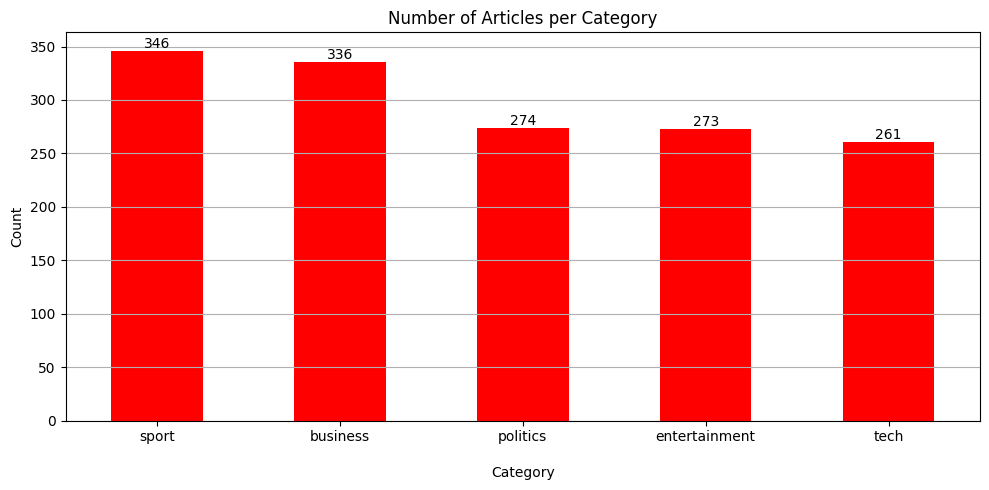

In [86]:
import matplotlib.pyplot as plt

# plot
ax = data_train['Category'].value_counts().plot(kind='bar', figsize=(10, 5), color='red')
plt.title("Number of Articles per Category")
plt.xlabel("\nCategory")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

Between our 5 unique catagories [sport, business, politics, entertainment, tech] we see somewhat even distribution. The mean articles per catagory, 1490/5 is 298. Thus from a quick standard deviation estimate:

$$
σ = \sqrt{\frac{1}{5} \sum_{i=1}^{5} (x_i - \bar{x})^2}
$$ 
= 
$$
\sqrt{\frac{1}{5} \sum_{i=1}^{5} (x_i - 298)^2}= 35.8
$$ 


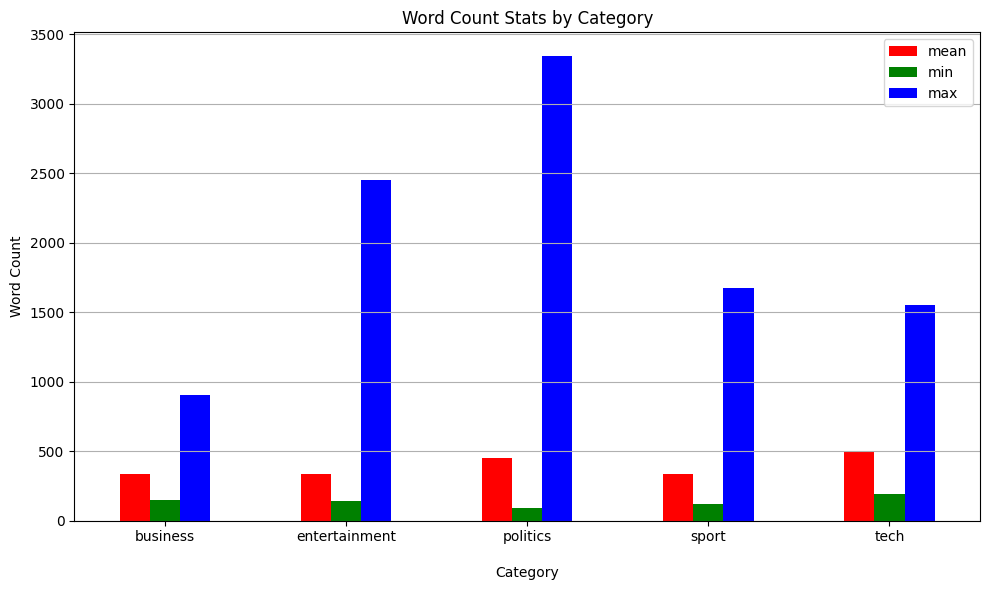

In [87]:
data_train["word_count"] = data_train["Text"].apply(lambda x: len(str(x).split()))

stats_train = data_train.groupby('Category')['word_count'].agg(['mean', 'min', 'max'])

stats_train.plot(kind='bar', figsize=(10, 6), color = {"red","blue","green"})
plt.title("Word Count Stats by Category")
plt.ylabel("Word Count")
plt.xlabel("\nCategory")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

From this histogram there is a huge range in the min and max word count of articles in each catagory. 
#### Removing Duplicates
There may be articles that contain more than more catagory. Thus Ill run a check, and remove any duplicats.

In [88]:
# Count unique categories per text
duplicates_across_categories = data_train.groupby("Text")["Category"].nunique()

# Count how many texts appear in more than one category
num_multi_category_texts = (duplicates_across_categories > 1).sum()

# Count total duplicate texts (before dropping duplicates)
total_duplicate_texts_before = data_train.duplicated(subset="Text", keep=False).sum()

print(f"Texts appearing in multiple categories: {num_multi_category_texts}")
print(f"Total duplicate texts (before dropping): {total_duplicate_texts_before}")

# Drop duplicate texts, keeping the first occurrence
data_train = data_train.drop_duplicates(subset="Text")

# Verify there are no remaining duplicate texts
total_duplicate_texts_after = data_train.duplicated(subset="Text", keep=False).sum()

print(f"Total duplicate texts (after dropping): {total_duplicate_texts_after}")

Texts appearing in multiple categories: 0
Total duplicate texts (before dropping): 100
Total duplicate texts (after dropping): 0


### Model Building and Training

Now that the data has been prepped I will build the model. This model, based on the assignment for this class, is to be built using sklearn's Non-Negative Matrix Factorization method. I will use the sklearn.deocmpositionNMF class found here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html


In [89]:
# Example: how many topics you want to find
n_topics = 5

# Combine train and test if you want consistent vectorization
all_texts = pd.concat([data_train['Text'], data_test['Text']], axis=0)

# Convert text to TF-IDF matrix
vectorizer = TfidfVectorizer(
    max_df=0.95,   # ignore very common words
    min_df=2,      # ignore very rare words
    stop_words='english'
)
tfidf = vectorizer.fit_transform(all_texts)

# Split back to train and test
tfidf_train = tfidf[:len(data_train)]
tfidf_test = tfidf[len(data_train):]

# Fit NMF on train data
nmf = NMF(
    n_components=n_topics,
    random_state=42,
    init='nndsvda'
)
W_train = nmf.fit_transform(tfidf_train)   # document-topic matrix
H = nmf.components_                        # topic-term matrix

# Transform test data
W_test = nmf.transform(tfidf_test)

print(f"Train topic distribution shape: {W_train.shape}")
print(f"Test topic distribution shape: {W_test.shape}")

# Example: top words per topic
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Train topic distribution shape: (1440, 5)
Test topic distribution shape: (735, 5)
Topic #1: england, game, win, wales, ireland, cup, said, team, play, half
Topic #2: mr, labour, election, blair, brown, party, said, government, minister, howard
Topic #3: mobile, people, music, said, phone, broadband, phones, digital, technology, users
Topic #4: film, best, awards, award, actor, actress, won, oscar, films, director
Topic #5: growth, economy, said, economic, sales, year, bank, market, oil, 2004


Here we can see keywords that are shared between articles.

In [90]:
model = NMF(n_components=5).fit(X_train)
y_pred_train = model.transform(X_train)
y_pred_train_as_int = y_pred_train.argmax(axis=1)
print(model)

import itertools

# Taken from assignment in week 2
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    label_encoder = LabelEncoder()
    y_true = label_encoder.fit_transform(ytdf.values.ravel())
    
    yp = np.array(yp)
    
    best_acc = 0
    best_perm = None
    
    for perm in itertools.permutations(range(n)):
        mapped_yp = [perm[label] for label in yp]
        acc = accuracy_score(y_true, mapped_yp)
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
    return best_perm, best_acc

perm, acc = label_permute_compare(data_train[['Category']], y_pred_train_as_int, n=5)

print("Accuracy for train data: ", acc)

ValueError: could not convert string to float: 'winter freeze keeps oil above $50 oil prices carried on rising on wednesday after cold weather on both sides of the north atlantic pushed us crude prices to four-month highs.  freezing temperatures and heavy snowfalls took crude oil prices past $50 a barrel on tuesday for the first time since november. declines in the dollar have also contributed to the rising oil price. us crude was trading at $51.39 at 0710 gmt in asian electronic trade on wednesday. a barrel of us crude oil closed up $2.80 at $51.15 in new york on tuesday. opec members said on tuesday that  given such high prices  the cartel saw no reason to cut its output.  although below last year s peak of $55.67 a barrel  which was reached in october  prices are now well above 2004 s average of $41.48. brent crude also rose in london trading  adding $1.89 to $48.62 at the close.  much of western europe and the north east of america has been shivering under unseasonably low temperatures in recent days. the decline in the us dollar to a five-week low against the euro has also served to inflate prices.  the primary factor is the weak dollar   said victor shum  a singapore-based analyst with purvin and gertz. expectations that a rebound in the dollar would halt the oil price rise were not immediately borne out on wednesday morning  as oil prices carried on upwards as the dollar strengthened against the euro  the pound and the yen.  several opec members said on tuesday that a cut in production was unlikely  citing rising prices and strong demand for oil from asia.  i agree that we do not need to cut supply if the prices are as much as this   fathi bin shatwan  libya s oil minister  told reuters.  i do not think we need to cut unless the prices are falling below $35 a barrel   he added.'

Lets take a look at a Confusion Matrix for the Data

In [ ]:
label_encoder = LabelEncoder()
y_true_train = label_encoder.fit_transform(data_train['Category'].values.ravel())

mapped_preds = [perm[label] for label in y_pred_train_as_int]

cm = confusion_matrix(y_true_train, mapped_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Greens", ax=ax)
plt.show()

In [ ]:
# transform and run model against test data
data_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
X_test = tfidf_vectorizer.transform(data_test.Text)
y_pred_test = model.transform(X_test)
y_pred_test_as_int = y_pred_test.argmax(axis=1)

mapped_preds_test = [perm[label] for label in y_pred_test_as_int]
predicted_labels_test = label_encoder.classes_[mapped_preds_test]

# Kaggle accuracy score: 
submission = pd.DataFrame({'ArticleId': data_test['ArticleId'],
                          'Category': predicted_labels_test})

submission.to_csv('submission.csv', index=False)

#### Hyperparameter Testing

### Comparision with Supervised Machine Learning

I am going to compare my unsupervised model with a supervised learning model. Here I use Gradient Boosted Method.

In [ ]:
data_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
data_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
BBC_Solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 📌 Load data
data_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
data_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

# ✅ Make a validation split from TRAIN to test your model
train_df, valid_df = train_test_split(
    data_train,
    test_size=0.2,
    random_state=42,
    stratify=data_train['Category']
)

X_train = train_df['Text']
y_train = train_df['Category']

X_valid = valid_df['Text']
y_valid = valid_df['Category']

# ✅ Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.95,
        min_df=2,
        stop_words='english'
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# ✅ Train
pipeline.fit(X_train, y_train)

# ✅ Validate
y_pred = pipeline.predict(X_valid)

print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))
print(f"\nValidation Accuracy: {accuracy_score(y_valid, y_pred):.4f}")

# ✅ Predict for submission
test_preds = pipeline.predict(data_test['Text'])

# ✅ Format submission
submission = pd.DataFrame({
    'Id': data_test['Id'],  # if your test file has an Id column
    'Category': test_preds
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved as submission.csv")

### Citation
Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.